In [5]:
from __future__ import print_function
#%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning23 as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import pickle
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [12]:
IMAGE_SHAPE = [73,60,3]
# Paths to data
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
TRAIN_PATH =  dataroot + "\\Data\\train.csv" 
VALID_PATH = dataroot + "\\Data\\valid.csv" 
TEST_PATH = dataroot + "\\Data\\test.csv" 
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3\\"
TARGET_COL = 'Smiling'
NUM_CLASSES = 2

# train holds both X (input) and t (target/truth)
data_train = data_utils.CelebADataset(TRAIN_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

#tuning the network round 1
df = pd.DataFrame(index=list(range(1,13)), columns=['layers','activations','conv_out_channels','kernel_size','conv_stride','maxpool'\
                                                    ,'dropout','batchnorm','optimizer','learning_rate','weight_decay','batch_size','num_epochs'\
                                                    ,'net','train_loss','train_accs','valid_loss','valid_accs'])


df['layers'] = 1

#adjust activation function
for i in range(1,7):
    df.at[i,'activations'] = [relu, relu, relu, relu]
for i in range(7,13):
    df.at[i,'activations'] = [tanh, tanh, tanh, tanh]
IMAGE_SHAPE = [73,60,3]
df['conv_out_channels'] = 16
df['kernel_size'] = 5
df['conv_stride'] = 1
df['maxpool'] = 1
df['dropout'] = 0.0
df['batchnorm'] = False
df['optimizer']='Adam'
df['learning_rate']=0.001
df['weight_decay']=0.0
df['batch_size']=128
df['num_epochs']=5

#adjust depth
df.at[5:6,'layers'] = 2
df.at[11:12,'layers'] = 2


#adjust channels
df.at[2,'conv_out_channels'] = 32 
df.at[3,'conv_out_channels'] = 64
df.at[4,'conv_out_channels'] = 128
df.at[5,'conv_out_channels'] = 32
df.at[6,'conv_out_channels'] = 64
df.at[8,'conv_out_channels'] = 32 
df.at[9,'conv_out_channels'] = 64
df.at[10,'conv_out_channels'] = 128
df.at[11,'conv_out_channels'] = 32
df.at[12,'conv_out_channels'] = 64 

In [26]:
for i in range(2,13):
    print('Model: ', i)
    layers = df.loc[i,'layers']
    activations = df.loc[i,'activations']
    conv_out_channels = df.loc[i,'conv_out_channels']
    kernel_size = df.loc[i,'kernel_size']
    conv_stride = df.loc[i,'conv_stride']
    maxpool = int(df.loc[i,'maxpool'])
    dropout = df.loc[i,'dropout']
    batchnorm = df.loc[i,'batchnorm']
    optimizer = df.loc[i,'optimizer']
    learning_rate = df.loc[i,'learning_rate']
    weight_decay = df.loc[i,'weight_decay']
    batch_size = int(df.loc[i,'batch_size'])
    num_epochs = df.loc[i,'num_epochs']
    
    net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)
    net_trained, df.at[i,'train_loss'], df.at[i,'train_accs'] = network_tuning.tune_train(net, data_train, optimizer, learning_rate, weight_decay, batch_size, num_epochs)
    df.at[i,'valid_loss'], df.at[i,'valid_accs'] = network_tuning.tune_valid(net, data_valid, batch_size)
    df.at[i,'net'] = 'model'+str(i)
    df.to_pickle('df.pkl')
    torch.save(net_trained.state_dict(), 'model'+str(i))

Model:  2
No GPU available.
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Model:  3
No GPU available.
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Model:  4
No GPU available.
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Model:  5
No GPU available.
Epoch:  0


KeyboardInterrupt: 

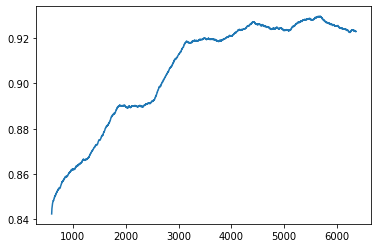

In [39]:
plt.plot(pd.Series(df.loc[4,'train_accs']).rolling(window=600).mean())

In [43]:
pd.Series(df.loc[1,'train_accs']).rolling(window=600).mean()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
6355    0.916862
6356    0.916849
6357    0.916732
6358    0.916706
6359    0.916753
Length: 6360, dtype: float64

In [57]:
np.mean(df.loc[4,'train_accs'][-400:])

0.9222146531939507

In [52]:
df

,layers,activations,conv_out_channels,kernel_size,conv_stride,maxpool,dropout,batchnorm,optimizer,learning_rate,weight_decay,batch_size,num_epochs,net,train_loss,train_accs,valid_loss,valid_accs
1,1,"[<function relu at 0x000001C881543EA0>, <funct...",16,5,1,1,0.0,False,Adam,0.001,0.0,128,5,model1,"[0.7170678973197937, 4.481327533721924, 1.6229...","[0.5390625, 0.46875, 0.6484375, 0.5703125, 0.6...",0.232076,0.904012
2,1,"[<function relu at 0x000001C881543EA0>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,model2,"[0.7973788380622864, 10.351090431213379, 5.913...","[0.4921875, 0.546875, 0.5859375, 0.6484375, 0....",0.224289,0.909901
3,1,"[<function relu at 0x000001C881543EA0>, <funct...",64,5,1,1,0.0,False,Adam,0.001,0.0,128,5,model3,"[0.8159742951393127, 32.093326568603516, 10.63...","[0.40625, 0.4921875, 0.640625, 0.6171875, 0.60...",0.2636,0.894498
4,1,"[<function relu at 0x000001C881543EA0>, <funct...",128,5,1,1,0.0,False,Adam,0.001,0.0,128,5,model4,"[0.8299558758735657, 41.132080078125, 18.75497...","[0.421875, 0.5546875, 0.6171875, 0.6171875, 0....",0.284481,0.902351
5,2,"[<function relu at 0x000001C881543EA0>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,NaN,NaN,NaN,NaN,NaN
6,2,"[<function relu at 0x000001C881543EA0>, <funct...",64,5,1,1,0.0,False,Adam,0.001,0.0,128,5,NaN,NaN,NaN,NaN,NaN
7,1,"[<function tanh at 0x000001C881544950>, <funct...",16,5,1,1,0.0,False,Adam,0.001,0.0,128,5,NaN,NaN,NaN,NaN,NaN
8,1,"[<function tanh at 0x000001C881544950>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,NaN,NaN,NaN,NaN,NaN
9,1,"[<function tanh at 0x000001C881544950>, <funct...",64,5,1,1,0.0,False,Adam,0.001,0.0,128,5,NaN,NaN,NaN,NaN,NaN
10,1,"[<function tanh at 0x000001C881544950>, <funct...",128,5,1,1,0.0,False,Adam,0.001,0.0,128,5,NaN,NaN,NaN,NaN,NaN
